# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

!pip install -U scikit-learn

import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap




#Part 1: Decision Trees

**Importing dataset**

In [5]:

data = pd.read_csv('preprocessed.csv')


## Training and visualizing

**Step 1: Categorizing Coffee Quality Based on Total Cup Points & Selecting Relevant Features**

In [8]:
if 'Total Cup Points' in data.columns:
    
    data['Total Cup Points/60'] = data['Total Cup Points'] / 60   #Normalize 'Total Cup Points' by dividing by 60 
    low_threshold = data['Total Cup Points/60'].quantile(0.33)
    high_threshold = data['Total Cup Points/60'].quantile(0.66)

    
    def categorize_quality(score):
        if score <= low_threshold:
            return 'Low Quality'
        elif score <= high_threshold:                     # Defining the quality categories based on percentiles
            return 'Moderate Quality'
        else:
            return 'High Quality'

    
    data['Quality Category'] = data['Total Cup Points/60'].apply(categorize_quality)  # Applying the categorization function to create a new column

    print(data['Quality Category'].value_counts())
else:
    print("Column 'Total Cup Points' not found in the dataframe.")


X = data[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall']].values  # Select relevant features
y = data['Quality Category'].values

Quality Category
Moderate Quality    71
High Quality        68
Low Quality         68
Name: count, dtype: int64


**Scaling and Applying PCA to the Data**

In [10]:
scaler = StandardScaler()                                # Scaling the data
data_scaled = scaler.fit_transform(X) 


pca = PCA(n_components=2)                              # Applying PCA to reduce to 2D
data_pca = pca.fit_transform(data_scaled) 


class_mapping = {'Low Quality': 0, 'Moderate Quality': 1, 'High Quality': 2}
y = np.array([class_mapping[label] for label in y], dtype=np.int64)

**Building a Decision Tree Classifier on PCA-Reduced Coffee Quality Data (Original -Depth 2)**

In [12]:
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(data_pca, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

**Plotting the decision tree classifier**

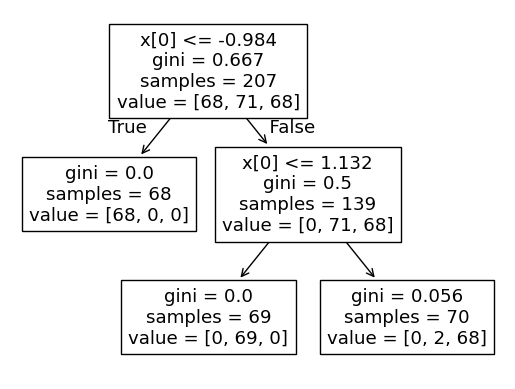

In [14]:
plot_tree(tree_clf_pca);

**Visualizing Decision Boundaries of the Decision Tree Classifier**

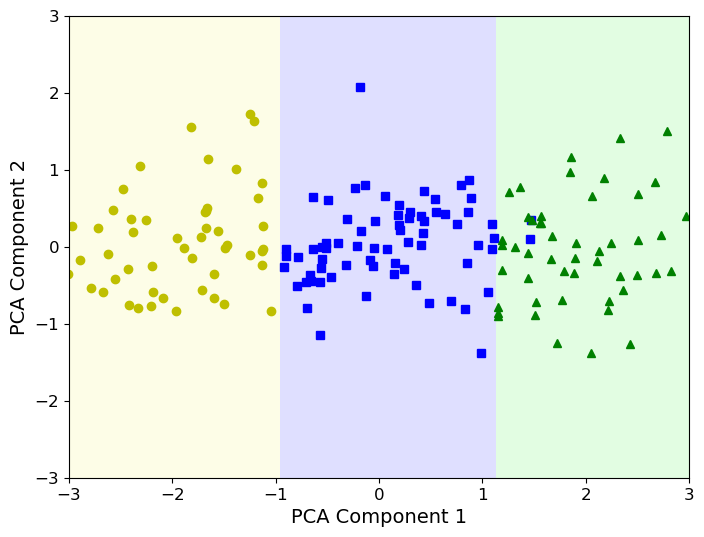

In [16]:
def plot_decision_boundary(clf, X, y, axes=[-3, 3, -3, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Low Quality")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Moderate Quality")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="High Quality")
        plt.axis(axes)

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


plt.figure(figsize=(8, 6))
plot_decision_boundary(tree_clf_pca, data_pca, y)     # Plot decision boundary
plt.show()


## Predicting classes and class probabilities

In [18]:
tree_clf_pca.predict_proba([[-2,0.9 ]])

array([[1., 0., 0.]])

In [19]:
tree_clf_pca.predict([[-2,0.9 ]])

array([0], dtype=int64)

**The code predicts the class probabilities and the final class label for a sample point [-2, 0.9] using the tree_clf_pca classifier. predict_proba outputs [1., 0., 0.], indicating full confidence in class 0, and predict confirms the prediction as class 0.**

## Sensitivity to training set details

More generally, the main issue with Decision Trees is that they are very sensitive to small variations in the training data. For example, if you just remove the widest Iris versicolor from the iris training set (the one with petals 4.8 cm long and 1.8 cm wide) and train a new Decision Tree, you may get the model represented as follows


In [23]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]

array([[ 0.37966361,  0.91513891, -0.36243735,  0.23064564,  0.46829486,
         0.41435502,  0.50124135]])

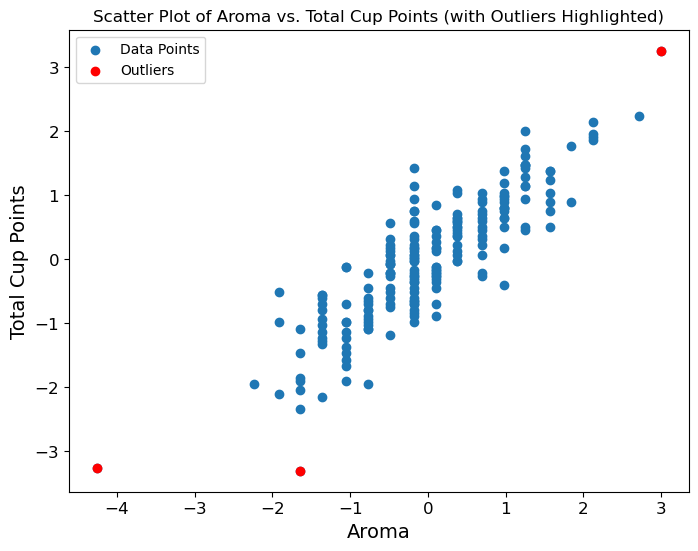

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('preprocessed.csv')  # Make sure the path is correct

# Convert 'Total Cup Points' to numeric if needed
data['Total Cup Points'] = pd.to_numeric(data['Total Cup Points'], errors='coerce')

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['Total Cup Points'].quantile(0.25)
Q3 = data['Total Cup Points'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Total Cup Points'] < lower_bound) | (data['Total Cup Points'] > upper_bound)]



# Scatter plot to visualize outliers in relation to another feature (e.g., Aroma)
plt.figure(figsize=(8, 6))
plt.scatter(data['Aroma'], data['Total Cup Points'], label='Data Points')
plt.scatter(outliers['Aroma'], outliers['Total Cup Points'], color='red', label='Outliers')
plt.title("Scatter Plot of Aroma vs. Total Cup Points (with Outliers Highlighted)")
plt.xlabel("Aroma")
plt.ylabel("Total Cup Points")
plt.legend()
plt.show()


In [25]:
# Identify outliers (as before)
outliers = data[(data['Total Cup Points'] < lower_bound) | (data['Total Cup Points'] > upper_bound)]

# To get the maximum outlier value
max_outlier_value = data['Total Cup Points'][data['Total Cup Points'] > upper_bound].max()

# Filter the dataset to find rows where 'Total Cup Points' is equal to the maximum outlier value
max_outliers = data[(data['Total Cup Points'] == max_outlier_value) & (data['Total Cup Points'] > upper_bound)]

# Display the maximum outlier rows
print(max_outliers)


   ID Country of Origin Processing Method     Aroma    Flavor  Aftertaste  \
0   0          Colombia             Other  2.993534  2.707661     2.98006   

    Acidity      Body   Balance   Overall         Color  \
0  3.436732  2.614819  3.034825  2.955285  Multicolored   

                     Altitude  Total Cup Points Continent of Origin  
0  High Altitude (1600-2000m)          3.257632             America  


In [26]:
# Assuming 'outliers' have already been identified as before
# Create a boolean mask to select non-outlier data
not_outliers = ~((data['Total Cup Points'] < lower_bound) | (data['Total Cup Points'] > upper_bound))

# Apply the mask to your dataset to exclude outliers
data_no_outliers = data[not_outliers]

# Alternatively, you can directly modify your original dataframe
data = data[not_outliers]

# Now, 'data_no_outliers' contains your dataset without the identified outliers
print(data_no_outliers)


      ID Country of Origin Processing Method     Aroma    Flavor  Aftertaste  \
1      1            Taiwan      Washed / Wet  2.714721  2.707661    1.163485   
2      2              Laos             Other  2.122244  2.420858    1.744789   
3      3        Costa Rica      Washed / Wet  1.250954  1.524596    2.071773   
4      4          Colombia             Other  2.122244  2.098204    1.744789   
5      5         Guatemala      Washed / Wet  2.122244  2.098204    2.362425   
..   ...               ...               ...       ...       ...         ...   
200  200       El Salvador     Natural / Dry -2.234207 -1.773645   -1.888360   
201  201            Brazil     Natural / Dry -1.641729 -2.060448   -1.561377   
202  202            Brazil     Natural / Dry -1.920542 -2.060448   -2.469664   
203  203         Nicaragua     Natural / Dry -1.362917 -2.383102   -3.087299   
204  204              Laos      Washed / Wet -1.641729 -2.060448   -1.888360   

      Acidity      Body   Balance   Ove

In [27]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale the tweaked data
scaler = StandardScaler()
X_tweaked_scaled = scaler.fit_transform(X_tweaked)

# Apply PCA to reduce tweaked data to 2D
pca = PCA(n_components=2)
X_tweaked_pca = pca.fit_transform(X_tweaked_scaled)

from sklearn.tree import DecisionTreeClassifier

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_tweaked.fit(X_tweaked_pca, y_tweaked)


DecisionTreeClassifier(max_depth=2, random_state=42)

[Text(0.4, 0.8333333333333334, 'x[0] <= -0.984\ngini = 0.667\nsamples = 207\nvalue = [68, 71, 68]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 68\nvalue = [68, 0, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[0] <= 1.132\ngini = 0.5\nsamples = 139\nvalue = [0, 71, 68]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 69\nvalue = [0, 69, 0]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.056\nsamples = 70\nvalue = [0, 2, 68]')]

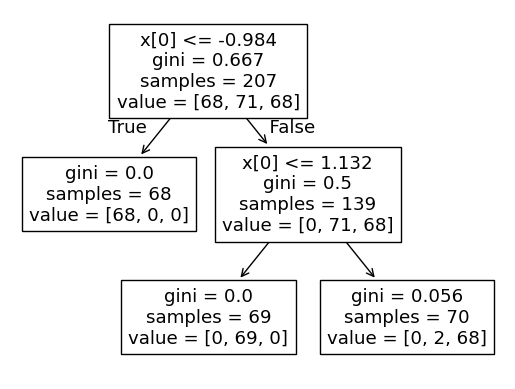

In [28]:
plot_tree(tree_clf_tweaked)



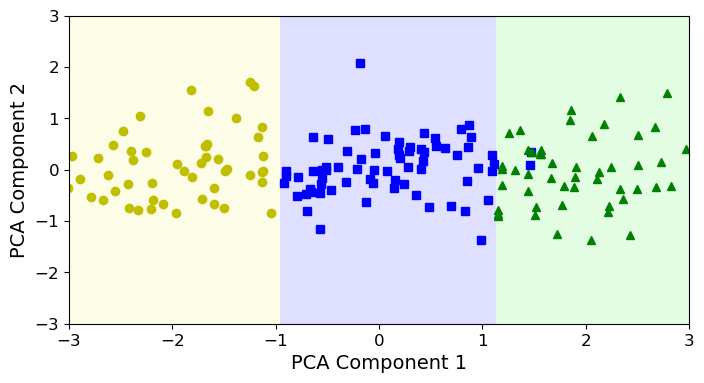

In [29]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked_pca, y_tweaked)
#plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
#plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
#plt.text(1.0, 0.9, "Depth=0", fontsize=15)
#plt.text(1.0, 1.80, "Depth=1", fontsize=13)
plt.show()

## Regularization Hyperparameters

**To avoid overfitting the training data, we need to restrict the Decision Tree’s freedom during training. This is called regularization.
Regularization hyperparameters for example can restrict the maximum depth of the Decision Tree.
This is controlled by the max_depth hyperparameter (the default value is None, which means unlimited). Reducing max_depth will regularize the model and thus reduce the risk of overfitting.**

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

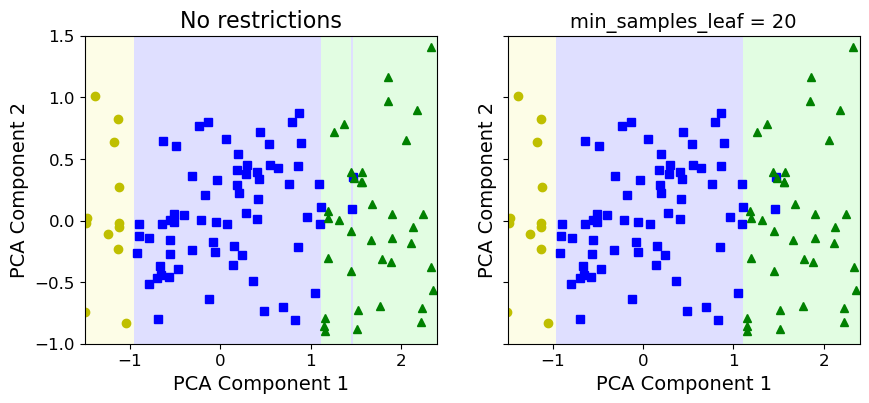

In [33]:
tree_clf_no_reg = DecisionTreeClassifier(random_state=42) # No regularization

tree_clf_reg = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)  # With min_samples_leaf regularization (20)

tree_clf_no_reg.fit(X_pca, y)
tree_clf_reg.fit(X_pca, y)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

# Plot the decision boundary for the tree with no regularization
plt.sca(axes[0])
plot_decision_boundary(tree_clf_no_reg, X_pca, y, axes=[-1.5, 2.4, -1, 1.5])
plt.title("No restrictions", fontsize=16)

# Plot the decision boundary for the tree with min_samples_leaf regularization
plt.sca(axes[1])
plot_decision_boundary(tree_clf_reg, X_pca, y, axes=[-1.5, 2.4, -1, 1.5])
plt.title("min_samples_leaf = {}".format(tree_clf_reg.min_samples_leaf), fontsize=14)


plt.show()



**The left plot shows a more complex decision boundary without restrictions, fitting closely to the data, while the right plot with min_samples_leaf=20 has a smoother, simplified boundary, indicating reduced overfitting.**

## Instability
**Decision Trees love orthogonal decision boundaries (all splits are perpendicular to an axis), which makes them sensitive to training set rotation.**

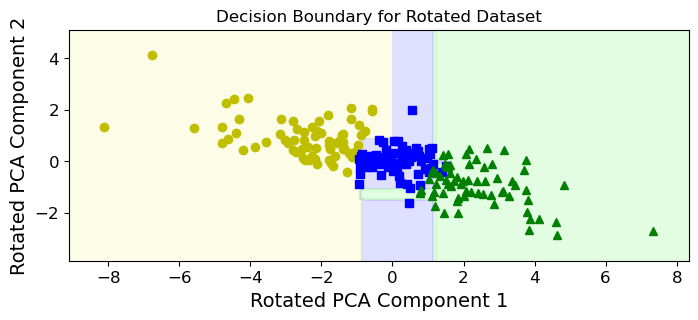

In [36]:
angle = np.pi / 180 * 20                    # Define the rotation matrix for a 20-degree rotation
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])


X_rotated = X_pca.dot(rotation_matrix)  #Rotate the 2D data


tree_clf_rotated = DecisionTreeClassifier(random_state=42)
tree_clf_rotated.fit(X_rotated, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_rotated, X_rotated, y, axes=[X_rotated[:, 0].min() - 1, X_rotated[:, 0].max() + 1,
                                                            X_rotated[:, 1].min() - 1, X_rotated[:, 1].max() + 1])
plt.xlabel("Rotated PCA Component 1")
plt.ylabel("Rotated PCA Component 2")
plt.title("Decision Boundary for Rotated Dataset")
plt.show()

**On the next example, left, a Decision Tree can split it easily, while on the right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily convoluted.**

NameError: name 'X_2d' is not defined

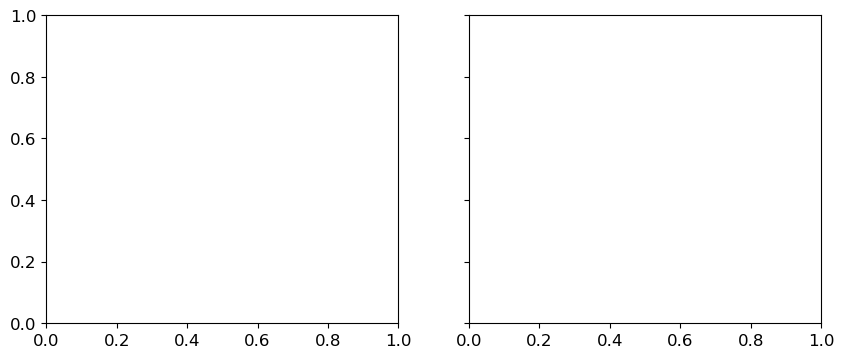

In [38]:

angle = np.pi / 4    #Define a 45-degree rotation matrix
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])


X_rotated = X_pca.dot(rotation_matrix)  #Apply the rotation to the 2D data


tree_clf_original = DecisionTreeClassifier(random_state=42)  # Train Decision Tree Classifiers on the original and rotated datasets
tree_clf_original.fit(X_pca, y)

tree_clf_rotated = DecisionTreeClassifier(random_state=42)
tree_clf_rotated.fit(X_rotated, y)


fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)


plt.sca(axes[0])
plot_decision_boundary(tree_clf_original, X_2d, y, axes=[X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5, X_pca[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5])
plt.title("Decision Boundary (Original Data)")


plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated, X_rotated, y, axes=[X_rotated[:, 0].min() - 0.5, X_rotated[:, 0].max() + 0.5, X_rotated[:, 1].min() - 0.5, X_rotated[:, 1].max() + 0.5])
plt.title("Decision Boundary (Rotated Data)")
plt.ylabel("")

plt.show()

**Illustrating how rotation affects the model's axis-aligned splits, resulting in a more fragmented boundary for the rotated data.**

## Depth Parameters-Experimenting with different depths-max_depth (default=None)

In [ ]:
tree_clf_pca1 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca1.fit(data_pca, y)

In [ ]:
tree_clf_pca2 = DecisionTreeClassifier(random_state=42)
tree_clf_pca2.fit(data_pca, y)

In [ ]:
tree_clf_pca3 = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_pca3.fit(data_pca, y)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Set up subplots to display each tree side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot each tree on its respective subplot
plot_tree(tree_clf_pca1, ax=axes[0], filled=True)
axes[0].set_title("tree_clf_pca1 (max_depth=2)")

plot_tree(tree_clf_pca2, ax=axes[1], filled=True)
axes[1].set_title("tree_clf_pca2 (no max_depth)")

plot_tree(tree_clf_pca3, ax=axes[2], filled=True)
axes[2].set_title("tree_clf_pca3 (max_depth=3)")

plt.show()


**If None (max_depth (default=None)), nodes are expanded until all leaves are pure or contain fewer than min_samples_split samples.**

**Controls overfitting: Deeper trees fit more detail but risk overfitting.**

In [ ]:


# Custom function to plot decision boundary
def plot_decision_boundary(clf, X, y, axes=[-3, 3, -3, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Low Quality")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Moderate Quality")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="High Quality")
        plt.axis(axes)

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

# Set up the three decision trees
tree_clf_pca1 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca1.fit(data_pca, y)

tree_clf_pca2 = DecisionTreeClassifier(random_state=42)
tree_clf_pca2.fit(data_pca, y)

tree_clf_pca3 = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf_pca3.fit(data_pca, y)

# Set up subplots to display each decision tree's boundary
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot for tree_clf_pca1 with max_depth=2
plt.sca(axes[0])
plot_decision_boundary(tree_clf_pca1, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_depth=2", fontsize=14)

# Plot for tree_clf_pca2 with no depth restriction
plt.sca(axes[1])
plot_decision_boundary(tree_clf_pca2, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("No max_depth restriction", fontsize=14)

# Plot for tree_clf_pca3 with max_depth=10
plt.sca(axes[2])
plot_decision_boundary(tree_clf_pca3, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_depth=10", fontsize=14)

plt.show()


In all three plots, the decision boundaries remain almost identical, despite using different max_depth settings (max_depth=2, no restriction, and max_depth=10). Each model produces similar boundaries between the classes, with clear separation in roughly the same regions.The lack of visible change in decision boundaries across different depths suggests that even a shallow tree can effectively separate the classes, as the PCA-transformed data is simple and well-separated in 2D space. Increasing the depth does not add complexity because the existing boundaries are sufficient.

## max_features (maximum number of features that are evaluated for splitting at each node).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Assuming data_pca and y have already been defined (PCA-reduced data and labels)

# Custom function to plot decision boundaries
def plot_decision_boundary(clf, X, y, axes=[-3, 3, -3, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Low Quality")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Moderate Quality")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="High Quality")
        plt.axis(axes)

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

# Create three Decision Trees with different max_features
tree_clf_maxf1 = DecisionTreeClassifier(max_features=1, random_state=42)
tree_clf_maxf2 = DecisionTreeClassifier(max_features=2, random_state=42)
tree_clf_maxf3 = DecisionTreeClassifier(max_features=None, random_state=42)  # No max_features restriction

# Fit each tree on the PCA-transformed data
tree_clf_maxf1.fit(data_pca, y)
tree_clf_maxf2.fit(data_pca, y)
tree_clf_maxf3.fit(data_pca, y)

# Plot decision boundaries for each tree
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot for tree with max_features=1
plt.sca(axes[0])
plot_decision_boundary(tree_clf_maxf1, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_features=1", fontsize=14)

# Plot for tree with max_features=2
plt.sca(axes[1])
plot_decision_boundary(tree_clf_maxf2, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_features=2", fontsize=14)

# Plot for tree with no max_features restriction
plt.sca(axes[2])
plot_decision_boundary(tree_clf_maxf3, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_features=None", fontsize=14)

plt.show()

# Visualize the structure of each tree
fig, tree_axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot tree structure for each tree
plot_tree(tree_clf_maxf1, ax=tree_axes[0], filled=True)
tree_axes[0].set_title("max_features=1")

plot_tree(tree_clf_maxf2, ax=tree_axes[1], filled=True)
tree_axes[1].set_title("max_features=2")

plot_tree(tree_clf_maxf3, ax=tree_axes[2], filled=True)
tree_axes[2].set_title("max_features=None")

plt.show()


**Changing max_features has a minimal impact on the decision boundaries and tree complexity in this dataset, possibly because the PCA-transformed data is simple and well-separated.**

## max_leaf_nodes (maximum number of leaf nodes)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.colors import ListedColormap

# Assuming data_pca and y have already been defined (PCA-reduced data and labels)

# Custom function to plot decision boundaries
def plot_decision_boundary(clf, X, y, axes=[-3, 3, -3, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)

    if plot_training:
        plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Low Quality")
        plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Moderate Quality")
        plt.plot(X[:, 0][y == 2], X[:, 1][y == 2], "g^", label="High Quality")
        plt.axis(axes)

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

# Create three Decision Trees with different max_leaf_nodes values
tree_clf_leaf1 = DecisionTreeClassifier(max_leaf_nodes=2, random_state=42)
tree_clf_leaf2 = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
tree_clf_leaf3 = DecisionTreeClassifier(random_state=42)

# Fit each tree on the PCA-transformed data
tree_clf_leaf1.fit(data_pca, y)
tree_clf_leaf2.fit(data_pca, y)
tree_clf_leaf3.fit(data_pca, y)

# Plot decision boundaries for each tree
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot for tree with max_leaf_nodes=3
plt.sca(axes[0])
plot_decision_boundary(tree_clf_leaf1, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_leaf_nodes=2", fontsize=14)

# Plot for tree with max_leaf_nodes=5
plt.sca(axes[1])
plot_decision_boundary(tree_clf_leaf2, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_leaf_nodes=3", fontsize=14)

# Plot for tree with max_leaf_nodes=10
plt.sca(axes[2])
plot_decision_boundary(tree_clf_leaf3, data_pca, y, axes=[-3, 3, -3, 3])
plt.title("max_leaf_nodes=none", fontsize=14)

plt.show()

# Visualize the structure of each tree
fig, tree_axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot tree structure for each tree
plot_tree(tree_clf_leaf1, ax=tree_axes[0], filled=True)
tree_axes[0].set_title("max_leaf_nodes=2")

plot_tree(tree_clf_leaf2, ax=tree_axes[1], filled=True)
tree_axes[1].set_title("max_leaf_nodes=3")

plot_tree(tree_clf_leaf3, ax=tree_axes[2], filled=True)
tree_axes[2].set_title("max_leaf_nodes=none")

plt.show()


As max_leaf_nodes increases, the tree structure and decision boundaries become more complex, allowing the model to capture more detail. A low max_leaf_nodes value (like 2) may underfit, while no limit on leaf nodes (None) may lead to overfitting. A moderate value (like 3) provides a balance between simplicity and accuracy.